<a href="https://colab.research.google.com/github/bassignana/Thesis/blob/master/SUPER_State_of_the_Art_Gluco_deepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import io
import keras
from datetime import timedelta, datetime
from sklearn import preprocessing, linear_model, datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from keras.layers import *
from keras.models import *
from keras.layers.convolutional import Conv1D, MaxPooling1D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded1 = files.upload()
uploaded2 = files.upload()
uploaded3 = files.upload()
uploaded4 = files.upload()
uploaded5 = files.upload()
uploaded6 = files.upload()

Saving df559_1 to df559_1 (2)


Saving df563_2 to df563_2 (2)


Saving df570_3 to df570_3 (2)


Saving df575_4 to df575_4 (2)


Saving df588_5 to df588_5 (2)


Saving df591_6 to df591_6 (2)


In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# To store dataset in a Pandas Dataframe
data1 = pd.read_csv(io.BytesIO(uploaded1['df559_1']))
data2 = pd.read_csv(io.BytesIO(uploaded2['df563_2']))
data3 = pd.read_csv(io.BytesIO(uploaded3['df570_3']))
data4 = pd.read_csv(io.BytesIO(uploaded4['df575_4']))
data5 = pd.read_csv(io.BytesIO(uploaded5['df588_5']))
data6 = pd.read_csv(io.BytesIO(uploaded6['df591_6']))

In [ ]:
def resample(data, freq):
    """
    :param data: dataframe
    :param freq: sampling frequency
    :return: resampled data between the the first day at 00:00:00 and the last day at 23:60-freq:00 at freq sample frequency
    """
    start = data.datetime.iloc[0].strftime('%Y-%m-%d') + " 00:00:00"
    end = datetime.strptime(data.datetime.iloc[-1].strftime('%Y-%m-%d'), "%Y-%m-%d") + timedelta(days=1) - timedelta(
        minutes=freq)
    index = pd.period_range(start=start,
                            end=end,
                            freq=str(freq) + 'min').to_timestamp()
    data = data.resample(str(freq) + 'min', on="datetime").agg({'glucose': np.mean, 'CHO': np.sum, "insulin": np.sum})
    data = data.reindex(index=index)
    data = data.reset_index()
    data = data.rename(columns={"index": "datetime"})
    return data

In [ ]:
def create_samples(data, ph, hist):
    n_samples = data.shape[0] - ph - hist + 1
    # number of rows
    y = data.loc[ph + hist - 1:, "glucose"].values.reshape(-1, 1)
    d = pd.DatetimeIndex(data.loc[ph + hist - 1:, "datetime"].values)
       # t = np.concatenate([np.arange(day_len) for _ in range(len(data) // day_len)], axis=0)[ph + hist - 1:].reshape(-1, 1)
    g = np.array([data.loc[i:i + n_samples - 1, "glucose"] for i in range(hist)]).transpose()
    c = np.array([data.loc[i:i + n_samples - 1, "CHO"] for i in range(hist)]).transpose()
    i = np.array([data.loc[i:i + n_samples - 1, "insulin"] for i in range(hist)]).transpose()
    
    new_columns = np.r_[["glucose_" + str(i) for i in range(hist)], ["CHO_" + str(i) for i in range(hist)], [
            "insulin_" + str(i) for i in range(hist)], ["y"]]
    len(new_columns)
    new_data = pd.DataFrame(data=np.c_[g, c, i, y], columns=new_columns)
    new_data["datetime"] = d
    new_data = new_data.loc[:, np.r_[["datetime"], new_columns]]  # reorder the columns, with datetime first
    return new_data




In [ ]:
"""
Implementation of Clarke and Parkes error grid analysis
"""
def clarke_error_zone_detailed(act, pred):
    """
    This function outputs the Clarke Error Grid region (encoded as integer)
    for a combination of actual and predicted value
    Based on 'Evaluating clinical accuracy of systems for self-monitoring of blood glucose':
    https://care.diabetesjournals.org/content/10/5/622
    """
    # Zone A
    if (act < 70 and pred < 70) or abs(act - pred) < 0.2 * act:
        return 0
    # Zone E - left upper
    if act <= 70 and pred >= 180:
        return 8
    # Zone E - right lower
    if act >= 180 and pred <= 70:
        return 7
    # Zone D - right
    if act >= 240 and 70 <= pred <= 180:
        return 6
    # Zone D - left
    if act <= 70 <= pred <= 180:
        return 5
    # Zone C - upper
    if 70 <= act <= 290 and pred >= act + 110:
        return 4
    # Zone C - lower
    if 130 <= act <= 180 and pred <= (7/5) * act - 182:
        return 3
    # Zone B - upper
    if act < pred:
        return 2
    # Zone B - lower
    return 1

def parkes_error_zone_detailed(act, pred, diabetes_type):
    """
    This function outputs the Parkes Error Grid region (encoded as integer)
    for a combination of actual and predicted value
    for type 1 and type 2 diabetic patients
    Based on the article 'Technical Aspects of the Parkes Error Grid':
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3876371/
    """
    def above_line(x_1, y_1, x_2, y_2, strict=False):
        if x_1 == x_2:
            return False

        y_line = ((y_1 - y_2) * act + y_2 * x_1 - y_1 * x_2) / (x_1 - x_2)
        return pred > y_line if strict else pred >= y_line

    def below_line(x_1, y_1, x_2, y_2, strict=False):
        return not above_line(x_1, y_1, x_2, y_2, not strict)

    def parkes_type_1(act, pred):
        # Zone E
        if above_line(0, 150, 35, 155) and above_line(35, 155, 50, 550):
            return 7
        # Zone D - left upper
        if (pred > 100 and above_line(25, 100, 50, 125) and
                above_line(50, 125, 80, 215) and above_line(80, 215, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 550, 150)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 50, 80) and
                above_line(50, 80, 70, 110) and above_line(70, 110, 260, 550)):
            return 4
        # Zone C - right lower
        if (act > 120 and below_line(120, 30, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 140, 170) and
                above_line(140, 170, 280, 380) and (act < 280 or above_line(280, 380, 430, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 170, 145) and
                below_line(170, 145, 385, 300) and (act < 385 or below_line(385, 300, 550, 450))):
            return 1
        # Zone A
        return 0

    def parkes_type_2(act, pred):
        # Zone E
        if (pred > 200 and above_line(35, 200, 50, 550)):
            return 7
        # Zone D - left upper
        if (pred > 80 and above_line(25, 80, 35, 90) and above_line(35, 90, 125, 550)):
            return 6
        # Zone D - right lower
        if (act > 250 and below_line(250, 40, 410, 110) and below_line(410, 110, 550, 160)):
            return 5
        # Zone C - left upper
        if (pred > 60 and above_line(30, 60, 280, 550)):
            return 4
        # Zone C - right lower
        if (below_line(90, 0, 260, 130) and below_line(260, 130, 550, 250)):
            return 3
        # Zone B - left upper
        if (pred > 50 and above_line(30, 50, 230, 330) and
                (act < 230 or above_line(230, 330, 440, 550))):
            return 2
        # Zone B - right lower
        if (act > 50 and below_line(50, 30, 90, 80) and below_line(90, 80, 330, 230) and
                (act < 330 or below_line(330, 230, 550, 450))):
            return 1
        # Zone A
        return 0

    if diabetes_type == 1:
        return parkes_type_1(act, pred)

    if diabetes_type == 2:
        return parkes_type_2(act, pred)

    raise Exception('Unsupported diabetes type')

clarke_error_zone_detailed = np.vectorize(clarke_error_zone_detailed)
parkes_error_zone_detailed = np.vectorize(parkes_error_zone_detailed)

def zone_accuracy(act_arr, pred_arr, mode='clarke', detailed=False, diabetes_type=1):
    """
    Calculates the average percentage of each zone based on Clarke or Parkes
    Error Grid analysis for an array of predictions and an array of actual values
    """
    acc = np.zeros(9)
    if mode == 'clarke':
        res = clarke_error_zone_detailed(act_arr, pred_arr)
    elif mode == 'parkes':
        res = parkes_error_zone_detailed(act_arr, pred_arr, diabetes_type)
    else:
        raise Exception('Unsupported error grid mode')

    acc_bin = np.bincount(res)
    acc[:len(acc_bin)] = acc_bin

    if not detailed:
        acc[1] = acc[1] + acc[2]
        acc[2] = acc[3] + acc[4]
        acc[3] = acc[5] + acc[6]
        acc[4] = acc[7] + acc[8]
        acc = acc[:5]

    return acc / sum(acc)

In [ ]:
def extract_training_data(data):
        """
        Extract the input variables (x), the time (t), and the objective (y) from the data samples.
        WARNING : need to be modified to include additional data, or override the function within the models
        :param data:
        :return:
        """
        
        y = data["y"]
        x = data.drop(["y", "datetime"], axis=1)

        return x, y


def extract_training_glucose(data):
        """
        Extract the input variables (x), the time (t), and the objective (y) from the data samples.
        WARNING : need to be modified to include additional data, or override the function within the models
        :param data:
        :return:
        """
        
        
        y = data["y"]
        x = data.filter(like='glucose',axis=1)
        return x, y


In [ ]:
dt = pd.DataFrame()
for data in [data1,data2,data3,data4,data5,data6]:
  data['datetime'] =  pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
  data_resampled = resample(data, 5)
  data_resampled['glucose'].isna().sum()
  data_resampled.dropna(inplace = True)
  data_resampled['glucose'].isna().sum()
#fill na's with zeros
  for col in data_resampled.columns:
      if "insulin" in col or "CHO" in col:
          data_resampled[col] = data_resampled[col].fillna(0)
  dt = pd.concat([data_resampled, dt])

In [ ]:
dt

,datetime,glucose,CHO,insulin
205,2021-11-30 17:05:00,160.0,0.0,0.0
206,2021-11-30 17:10:00,158.0,0.0,0.0
207,2021-11-30 17:15:00,160.0,0.0,0.0
208,2021-11-30 17:20:00,166.0,0.0,0.0
209,2021-11-30 17:25:00,175.0,0.0,0.0
...,...,...,...,...
12091,2022-01-17 23:35:00,161.0,0.0,0.0
12092,2022-01-17 23:40:00,164.0,0.0,0.0
12093,2022-01-17 23:45:00,168.0,0.0,0.0
12094,2022-01-17 23:50:00,172.0,0.0,0.0


In [ ]:
#data['datetime'] =  pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
#data

,datetime,glucose,CHO,insulin
0,2021-12-07 01:08:04,NaN,NaN,1.6
1,2021-12-07 01:17:00,101.0,NaN,NaN
2,2021-12-07 01:22:00,98.0,NaN,NaN
3,2021-12-07 01:27:00,104.0,NaN,NaN
4,2021-12-07 01:32:00,112.0,NaN,NaN
...,...,...,...,...
11280,2022-01-13 23:38:00,266.0,NaN,NaN
11281,2022-01-13 23:43:00,275.0,NaN,NaN
11282,2022-01-13 23:48:00,268.0,NaN,NaN
11283,2022-01-13 23:53:00,301.0,NaN,NaN


In [ ]:
#data_resampled = resample(data, 5)

In [ ]:
#data_resampled

,datetime,glucose,CHO,insulin
0,2021-12-07 00:00:00,133.000000,0.0,0.0
1,2021-12-07 00:05:00,129.000000,0.0,0.0
2,2021-12-07 00:10:00,126.000000,0.0,0.0
3,2021-12-07 00:15:00,126.500000,0.0,0.0
4,2021-12-07 00:20:00,124.000000,0.0,0.0
...,...,...,...,...
10939,2022-01-13 23:35:00,185.000000,0.0,4.1
10940,2022-01-13 23:40:00,186.666667,0.0,0.0
10941,2022-01-13 23:45:00,183.000000,0.0,0.0
10942,2022-01-13 23:50:00,193.000000,0.0,0.0


In [ ]:
#data_resampled

In [ ]:
#data_resampled['glucose'].isna().sum()

0

In [ ]:
#data_resampled["glucose"].interpolate(method = "polynomial", order = 5, inplace = True, limit = 5)#impostare limit se no vengono dei valori di glucosio negativi


In [ ]:
#data_resampled['glucose'].isna().sum()

0

In [ ]:
#data_resampled.dropna(inplace = True)
#data_resampled['glucose'].isna().sum()

0

In [ ]:
#fill na's with zeros
#for col in data_resampled.columns:
#    if "insulin" in col or "CHO" in col:
#        data_resampled[col] = data_resampled[col].fillna(0)

In [ ]:
data_resampled = dt
#train test split
n = len(data_resampled)
#n
train_df = data_resampled[0:int(n*0.9)]
test_df = data_resampled[int(n*0.9):int(n*1)]
#train_df.shape
#test_df.shape

In [ ]:
#dati per il riscaling
risc_min = train_df['glucose'].min()
risc_range = train_df['glucose'].max()-train_df['glucose'].min()

In [ ]:
#standardizzazione
x_cols = [x for x in train_df.columns if x != 'datetime']
min_max_scaler = preprocessing.MinMaxScaler()# 0 1 scale
train_df = min_max_scaler.fit_transform(train_df[x_cols])
#handle sparses data well, but re read documentation
#how to apply the same transformation to the tast set
#check if correct!
test_df = min_max_scaler.transform(test_df[x_cols])
#recreate the dataframe
train_df = pd.DataFrame(data=train_df, columns=x_cols)
test_df = pd.DataFrame(data=test_df, columns=x_cols)

train_df.shape
test_df.shape

(6926, 3)

In [ ]:
train_df["datetime"] = pd.DatetimeIndex(data_resampled.iloc[:int(len(train_df["glucose"])), 0].values)
test_df["datetime"] = pd.DatetimeIndex(data_resampled.iloc[len(train_df["glucose"]):n, 0].values)

train_df = train_df[['datetime',"glucose", "CHO", "insulin"]]
test_df = test_df[['datetime',"glucose", "CHO", "insulin"]]

#train_df.shape
#test_df.shape

In [ ]:
train = create_samples(train_df, 6, 24)
train.dropna(inplace = True)   

test = create_samples(test_df, 6, 24)
test.dropna(inplace = True)

In [ ]:
######################################################################
#basic univariate lstm models
######################################################################

In [ ]:
xtrain, ytrain = extract_training_glucose(train)
xtest, ytest = extract_training_glucose(test)

In [ ]:
xtrain.values.shape
xtrain_lstm = xtrain.values.reshape((xtrain.shape[0],xtrain.shape[1],1))
#xtrain_lstm.shape#ok



In [ ]:
xtest_lstm = xtest.values.reshape((xtest.shape[0],xtest.shape[1],1))
#xtest_lstm.shape#ok

In [ ]:
n_steps = xtrain_lstm.shape[1]
n_features = 1

In [ ]:
#vanilla lstm

In [ ]:
# define model vanilla 
#model = Sequential()
#model.add(LSTM(20, activation='relu', input_shape=(n_steps,
#n_features)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mse')

# fit model
#model.fit(xtrain_lstm, ytrain, epochs=100, verbose=1)



In [ ]:
# mi servono xtest rescaled e y test rescaled per la CV
#xtest_resc = xtest.transform(lambda x: x*risc_range + risc_min )
#xtest_resc_lstm = xtest_resc.values.reshape((xtest_resc.shape[0],xtest_resc.shape[1],1))
#xtest_resc_lstm.shape#ok


In [ ]:
#yhat = model.predict(xtest_lstm, verbose=0)

#yhat.shape

In [ ]:
#per rifare lo scaling al contrario devo moltiplicare ogni valore di yhat per il resc range ed aggiungervi il minimo
#yhat_rescaled = yhat*risc_range + risc_min

In [ ]:
ytest_rescaled = ytest*risc_range + risc_min

In [ ]:
clarke_results = pd.DataFrame()
err_results = pd.DataFrame()

Se l'sltm segnala che non userà cuDNN provare a fare ciò che è srcritto qui

The requirements to use the cuDNN implementation are:
*   activation == tanh
*   recurrent_activation == sigmoid
*   recurrent_dropout == 0
*   unroll is False
*   use_bias is True
*   Inputs, if use masking, are strictly right-padded.
*   Eager execution is enabled in the outermost context.


You can use a trained model without having to retrain it, or pick-up training where you left off in case the training process was interrupted. The tf.keras.callbacks.ModelCheckpoint callback allows you to continually save the model both during and at the end of training.

In [ ]:
# Include the epoch in the file name (uses `str.format`)
#checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)


#cp_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_path, 
#    monitor = 'val_loss'
#    mode = 'min',
#    verbose=1, 
#    save_weights_only = True,
#    save_best_only = True)

#es_callback = tf.keras.callbacks.EarlyStopping(
#    monitor='val_loss', min_delta=0.0005, patience=0, verbose=0, mode='min',
#    baseline=None, restore_best_weights=True
#)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='tr_loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [ ]:
# CNN LSTM
# se ho 24 colonne nel livello di glucosio li devo dividere in un tot di sequenze n_seq con ognuna un tot di colonne n_steps
# es 2*12

n_seq = 2
n_steps = 12
n_features = 1
xtrain_CNN_lstm = xtrain.values.reshape((xtrain.shape[0], n_seq, n_steps, n_features))
xtest_CNN_lstm = xtest.values.reshape((xtest.shape[0],n_seq, n_steps, n_features))

In [ ]:
xtrain_CNN_lstm.shape

(62300, 2, 12, 1)

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_4/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor = 'val_loss',
    mode = 'min',
    verbose=0, 
    save_weights_only = True,
    save_best_only = True)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.00000001, patience=100000, verbose=0, mode='min',
    baseline=None, restore_best_weights=True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                     factor=0.2, 
                                     patience=10, 
                                     verbose=1, 
                                     mode='min',    
                                     min_delta=0.001, 
                                     cooldown=0, 
                                     min_lr=0)

In [ ]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu'), input_shape=(None, n_steps, n_features))) 
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128, activation='tanh', dropout = 0.3)) 
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse') # fit model


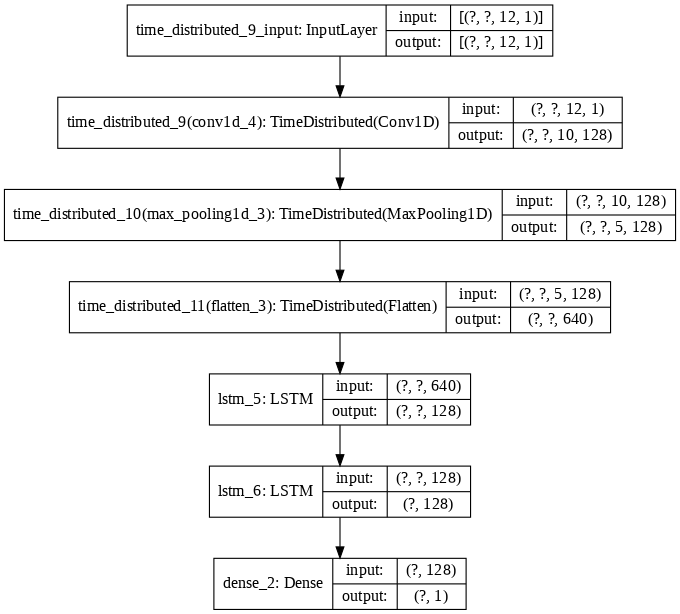

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=80
)

In [ ]:
history = model.fit(xtrain_CNN_lstm, ytrain, epochs=200, verbose=1,validation_split= 0.2,callbacks=[cp_callback, es_callback, lr_callback])

Epoch 1/200
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 2/200
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 3/200
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 4/200
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 5/200
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 6/200
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 7/200
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 8/200
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 9/200
1558/1558 [==============================] - 6s 4ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 10/200
1558/1558 [==============================] - 6s 4ms/step - l

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,lr,epoch
195,0.002348,0.005224,5.242880e-17,195
196,0.002376,0.005224,5.242880e-17,196
197,0.002383,0.005224,5.242880e-17,197
198,0.002378,0.005224,5.242880e-17,198
199,0.002372,0.005224,5.242880e-17,199


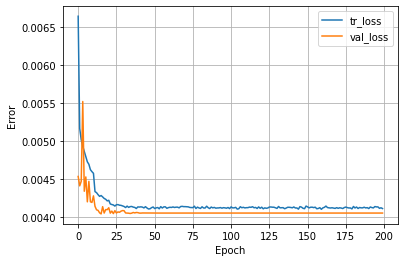

In [ ]:
plot_loss(history)

In [ ]:
yhat = model.predict(xtest_CNN_lstm, verbose=0)
yhat_rescaled = yhat*risc_range + risc_min
rmse = sqrt(mean_squared_error(ytest_rescaled, yhat_rescaled)) 
print('Test RMSE: %.3f' % rmse)

Test RMSE: 27.642


In [ ]:
yy = yhat_rescaled.reshape(yhat_rescaled.shape[0])
res = zone_accuracy(ytest_rescaled, yy, mode='clarke', detailed=False, diabetes_type=1)
clarke_results = clarke_results.append(pd.DataFrame(res), ignore_index=False, verify_integrity=False, sort=None)
a = max_error(ytest_rescaled, yy)
b = sqrt(mean_squared_error(ytest_rescaled, yhat_rescaled))
c = mean_absolute_error(ytest_rescaled, yy)
resarr = [a,b,c]
err_results = err_results.append(pd.DataFrame(resarr))

In [ ]:
err_results

,0
0,51.047150
1,13.958291
2,10.548484


In [ ]:
clarke_results

,0
0,0.976548
1,0.023452
2,0.000000
3,0.000000
4,0.000000


In [ ]:
tot_iter = 10

es_monitor = ['val_loss']*tot_iter
es_min_delta = [0.00000001]*tot_iter
es_patience = [100000]*tot_iter
es_mode = ['min']*tot_iter
ls_monitor=['val_loss']*tot_iter
ls_factor=list(np.linspace(start = 0.001, stop = 0.999, num = tot_iter)) 
ls_patience=[10]*tot_iter 
ls_verbose=[1]*tot_iter 
ls_mode=['min']*tot_iter    
ls_min_delta=[0.001]*tot_iter
ls_cooldown=[0]*tot_iter
ls_min_lr=[0]*tot_iter
filters=[128]*tot_iter
kernel_size=[3]*tot_iter
activation=['relu']*tot_iter
pool_size=[2]*tot_iter
lstm_units=[128]*tot_iter
lstm_dropout=[0.3]*tot_iter
learning_rate=[0.001]*tot_iter
epochs=[200]*tot_iter

#essendo zip un iterabile, dopo il primo giro sparisce tutto se non assegno list() a qualcosa
par = list(zip(es_monitor ,
es_min_delta ,
es_patience ,
es_mode ,#3
ls_monitor,
ls_factor, 
ls_patience, 
ls_verbose, 
ls_mode,    
ls_min_delta,
ls_cooldown,
ls_min_lr,#11
filters,
kernel_size,
activation,
pool_size,#15
lstm_units,
lstm_dropout,
learning_rate,
epochs))

In [ ]:
#ricordarsi che nel range non genera anche la cifra d'arrivo
for i in range(0,tot_iter):
  # Include the epoch in the file name (uses `str.format`)
  checkpoint_path = "training_4/cp-{epoch:04d}.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor = 'val_loss',
    mode = 'min',
    verbose=0, 
    save_weights_only = True,
    save_best_only = True)

  es_callback = tf.keras.callbacks.EarlyStopping(
    monitor=par[i][0], min_delta=par[i][1], patience=par[i][2], verbose=0, mode=par[i][3],
    baseline=None, restore_best_weights=True
  )

  lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor=par[i][4], 
                                     factor=par[i][5], 
                                     patience=par[i][6], 
                                     verbose=par[i][7], 
                                     mode=par[i][8],    
                                     min_delta=par[i][9], 
                                     cooldown=par[i][10], 
                                     min_lr=par[i][11])
  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=par[i][12], kernel_size=par[i][13], activation=par[i][14]), input_shape=(None, n_steps, n_features))) 
  model.add(TimeDistributed(MaxPooling1D(pool_size=par[i][15])))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(par[i][16], activation='tanh', dropout = par[i][17])) 
  model.add(Dense(1))
  opt = keras.optimizers.Adam(learning_rate=par[i][18])
  model.compile(optimizer=opt, loss='mse') 
  # fit model
  history = model.fit(xtrain_CNN_lstm, ytrain, epochs=par[i][19], verbose=1,validation_split= 0.2,callbacks=[cp_callback, es_callback, lr_callback])
  yhat = model.predict(xtest_CNN_lstm, verbose=0)
  yhat_rescaled = yhat*risc_range + risc_min
  #
  yy = yhat_rescaled.reshape(yhat_rescaled.shape[0])
  res = zone_accuracy(ytest_rescaled, yy, mode='clarke', detailed=False, diabetes_type=1)
  clarke_results = clarke_results.append(pd.DataFrame(res), ignore_index=False, verify_integrity=False, sort=None)
  a = max_error(ytest_rescaled, yy)
  b = sqrt(mean_squared_error(ytest_rescaled, yhat_rescaled))
  c = mean_absolute_error(ytest_rescaled, yy)
  resarr = [a,b,c]
  err_results = err_results.append(pd.DataFrame(resarr))
  err_results.to_csv('err.csv')
  clarke_results.to_csv('clk.csv') 
  !cp err.csv "/content/drive/My Drive/Risultati_NN"
  !cp clk.csv "/content/drive/My Drive/Risultati_NN"

  


Epoch 1/200
285/285 [==============================] - 1s 5ms/step - loss: 0.0075 - val_loss: 0.0012
Epoch 2/200
285/285 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 3/200
285/285 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/200
285/285 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 8.5215e-04
Epoch 5/200
285/285 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 8.6195e-04
Epoch 6/200
285/285 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss: 7.3498e-04
Epoch 7/200
285/285 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 8.9541e-04
Epoch 8/200
285/285 [==============================] - 1s 4ms/step - loss: 0.0014 - val_loss: 7.0053e-04
Epoch 9/200
285/285 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 6.8561e-04
Epoch 10/200
285/285 [==============================] - 1s 4ms/step

In [ ]:
clarke_results

NameError: ignored

In [ ]:
err_results